In [16]:
import numpy as np
import os
import pandas as pd

# Load the .npz file
with np.load('cifar4-train.npz') as data:
    cifar4_data = dict(data.items())

print('It is a dictionary with keys:', list(cifar4_data.keys()))

It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [17]:
X=cifar4_data['overfeat']
y=cifar4_data['labels']
P=cifar4_data['pixels']

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
    
# Create train set
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=1800, random_state=0)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=1000, random_state=0)

# Rescale input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (3200, 4096) (3200,)
Valid: (800, 4096) (800,)
Test: (1000, 4096) (1000,)


In [11]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y))
    np.random.shuffle(shuffled_idx)
    
    
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [12]:
import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders for input and putput
    X = tf.placeholder(dtype=tf.float32, shape=[None, 4096])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    # Hidden layer with 64 units and RELU activation
    hidden = tf.layers.dense(
        X, 64, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    
    
   
    # Output layer
    logits = tf.layers.dense(
        hidden, 10, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )
    
    
    # Get weights of the first hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
    
    # Dropout on the hidden layer
    training = tf.placeholder(dtype=tf.bool)
    hidden = tf.layers.dropout(hidden, rate=0.5, seed=0, training=training)
    
        
    #Get weights of the second tensor
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
    
    
    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)

    
    # Loss fuction: mean cross-entropy with regularization on W1 and W2
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    regularizer_W1=tf.nn.l2_loss(W1)
    regularizer_W2=tf.nn.l2_loss(W2)
    
    loss=tf.reduce_mean(loss+alpha*regularizer_W1+alpha*regularizer_W2)
    
    
    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(loss)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [13]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        # Get batches of data
        for X_batch, y_batch in get_batches(X_train, y_train, 50):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001, # Learning rate
                training: False, # Apply dropout
                alpha: 0.005 # Regularization strength

            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
        
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_test,
        y: y_test
        
    
    })
        
    print('Multilayer fully-connected network accuracy (test set) {:.3f}'.format(test_acc))
    
    
    # to get the prediction of the class
    predictions=sess.run(predictions,feed_dict={
        X: X_test,
        y: y_test
        
    
    })
        
    # Weights of the hidden layer
    weights_hidden_W1 = W1.eval()
    weights_W2 = W2.eval()

Epoch 1 - valid: 0.531 train: 0.301 (mean)
Epoch 2 - valid: 0.691 train: 0.648 (mean)
Epoch 3 - valid: 0.749 train: 0.743 (mean)
Epoch 4 - valid: 0.766 train: 0.779 (mean)
Epoch 5 - valid: 0.788 train: 0.798 (mean)
Epoch 6 - valid: 0.793 train: 0.808 (mean)
Epoch 7 - valid: 0.798 train: 0.817 (mean)
Epoch 8 - valid: 0.800 train: 0.822 (mean)
Epoch 9 - valid: 0.805 train: 0.828 (mean)
Epoch 10 - valid: 0.808 train: 0.831 (mean)
Epoch 11 - valid: 0.810 train: 0.836 (mean)
Epoch 12 - valid: 0.810 train: 0.839 (mean)
Epoch 13 - valid: 0.810 train: 0.842 (mean)
Epoch 14 - valid: 0.809 train: 0.843 (mean)
Epoch 15 - valid: 0.809 train: 0.848 (mean)
Epoch 16 - valid: 0.810 train: 0.851 (mean)
Epoch 17 - valid: 0.811 train: 0.856 (mean)
Epoch 18 - valid: 0.814 train: 0.857 (mean)
Epoch 19 - valid: 0.811 train: 0.859 (mean)
Epoch 20 - valid: 0.815 train: 0.864 (mean)
Epoch 21 - valid: 0.815 train: 0.866 (mean)
Epoch 22 - valid: 0.816 train: 0.868 (mean)
Epoch 23 - valid: 0.816 train: 0.870 (mea

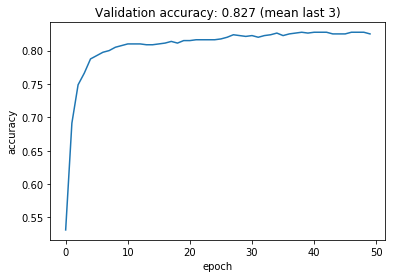

In [13]:
# I plot the evolution of the validation accuracy
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:])
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [14]:
# I check that the predictect classes are uniformly distributed

df_results=pd.DataFrame(predictions, columns=['Forecast'])
df_results['Count']=1
df_results.groupby(by="Forecast").count()

,Count
Forecast,
0,272
1,237
2,238
3,253
